In [2]:
!pip install biopython scikit-learn tensorflow openpyxl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 85.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd

from Bio import SeqIO

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    matthews_corrcoef, cohen_kappa_score,
    roc_auc_score, confusion_matrix
)
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

from google.colab import files


In [4]:
uploaded = files.upload()


Saving PSSP.xlsx to PSSP.xlsx
Saving proteinStructure.fasta to proteinStructure.fasta


In [5]:
# Heliks eğilimi (Pa)
Pa = {
    "A": 1.45, "R": 1.00, "N": 0.67, "D": 1.01, "C": 0.77,
    "Q": 1.11, "E": 1.51, "G": 0.57, "H": 1.00, "I": 1.08,
    "L": 1.34, "K": 1.07, "M": 1.20, "F": 1.12, "P": 0.57,
    "S": 0.77, "T": 0.83, "W": 1.14, "Y": 0.61, "V": 1.06
}

# Beta sheet eğilimi (Pb)
Pb = {
    "A": 0.97, "R": 0.90, "N": 0.89, "D": 0.54, "C": 1.30,
    "Q": 1.10, "E": 0.37, "G": 0.75, "H": 0.87, "I": 1.60,
    "L": 1.22, "K": 0.74, "M": 1.67, "F": 1.28, "P": 0.55,
    "S": 0.75, "T": 1.19, "W": 1.19, "Y": 1.29, "V": 1.70
}

# Turn eğilimi (Pt) – örnek tablo
Pt = {
    "A": 0.66, "R": 0.95, "N": 1.56, "D": 1.46, "C": 1.19,
    "Q": 0.98, "E": 0.74, "G": 1.56, "H": 0.95, "I": 0.47,
    "L": 0.59, "K": 1.01, "M": 0.60, "F": 0.60, "P": 1.52,
    "S": 1.43, "T": 0.96, "W": 0.96, "Y": 1.14, "V": 0.50
}


In [6]:
fasta_name = "proteinStructure.fasta"

sequences = []
labels = []
ids = []

for record in SeqIO.parse(fasta_name, "fasta"):
    seq = str(record.seq)
    sequences.append(seq)
    ids.append(record.id)

    # skorları topla
    h_score = sum(Pa.get(a, 0) for a in seq)
    b_score = sum(Pb.get(a, 0) for a in seq)
    t_score = sum(Pt.get(a, 0) for a in seq)

    scores = {
        "Helix": h_score,
        "Sheet": b_score,
        "Turn": t_score
    }

    label = max(scores, key=scores.get)
    labels.append(label)

df_cf = pd.DataFrame({
    "ProteinID": ids,
    "Sequence": sequences,
    "Class": labels
})

df_cf.head()


,ProteinID,Sequence,Class
0,1,CAFSIFRGFTCCPWPIMNVN,Sheet
1,2,DNSIQGLGKIDSKACPRPRG,Turn
2,3,DDFQQLANWIGNLGCTSRCQ,Turn
3,4,ILRFWGPYFSMILNWKCCCG,Sheet
4,5,FTWCEANEIDYPHQWYTSGE,Turn


In [7]:
# Chou-Fasman sonuçlarını Excel dosyasına kaydet
cf_output_path = "chou_fasman_results.xlsx"
df_cf.to_excel(cf_output_path, index=False)
print(f"Chou-Fasman sonuçları '{cf_output_path}' dosyasına kaydedildi.")


Chou-Fasman sonuçları 'chou_fasman_results.xlsx' dosyasına kaydedildi.


In [8]:
EIIP = {
    "A": 0.0373, "C": 0.0829, "D": 0.1260, "E": 0.0058,
    "F": 0.0946, "G": 0.0050, "H": 0.0242, "I": 0.0946,
    "K": 0.0371, "L": 0.0959, "M": 0.0823, "N": 0.0036,
    "P": 0.0198, "Q": 0.0761, "R": 0.0959, "S": 0.0829,
    "T": 0.0941, "V": 0.0057, "W": 0.0548, "Y": 0.0516
}

eiip_vectors = []

for seq in df_cf["Sequence"]:
    vec = [EIIP.get(a, 0.0) for a in seq]
    eiip_vectors.append(vec)

df_cf["EIIP"] = eiip_vectors
df_cf.head()


,ProteinID,Sequence,Class,EIIP
0,1,CAFSIFRGFTCCPWPIMNVN,Sheet,"[0.0829, 0.0373, 0.0946, 0.0829, 0.0946, 0.094..."
1,2,DNSIQGLGKIDSKACPRPRG,Turn,"[0.126, 0.0036, 0.0829, 0.0946, 0.0761, 0.005,..."
2,3,DDFQQLANWIGNLGCTSRCQ,Turn,"[0.126, 0.126, 0.0946, 0.0761, 0.0761, 0.0959,..."
3,4,ILRFWGPYFSMILNWKCCCG,Sheet,"[0.0946, 0.0959, 0.0959, 0.0946, 0.0548, 0.005..."
4,5,FTWCEANEIDYPHQWYTSGE,Turn,"[0.0946, 0.0941, 0.0548, 0.0829, 0.0058, 0.037..."


In [11]:
# Maksimum dizi uzunluğunu bul
max_len = max(len(v) for v in eiip_vectors)
print("Maksimum aminoasit uzunluğu:", max_len)

from tensorflow.keras.preprocessing.sequence import pad_sequences

X = pad_sequences(eiip_vectors, maxlen=max_len, padding='post', dtype='float32')




Maksimum aminoasit uzunluğu: 20


In [12]:
# EIIP vektörlerini DataFrame'e dönüştür (her sütun EIIP_1, EIIP_2, ...)
eiip_padded = X  # pad_sequences sonucu (num_samples x max_len)
eiip_df = pd.DataFrame(eiip_padded, columns=[f"EIIP_{i+1}" for i in range(eiip_padded.shape[1])])

# ProteinID ve Class sütunlarını başa ekle
eiip_df.insert(0, "ProteinID", df_cf["ProteinID"].values)
eiip_df.insert(1, "Class", df_cf["Class"].values)

eiip_output_path = "eiip_dataset.xlsx"
eiip_df.to_excel(eiip_output_path, index=False)
print(f"EIIP veri seti '{eiip_output_path}' dosyasına kaydedildi.")


EIIP veri seti 'eiip_dataset.xlsx' dosyasına kaydedildi.


In [13]:
y_str = df_cf["Class"].values
classes = sorted(df_cf["Class"].unique())
class_to_int = {c: i for i, c in enumerate(classes)}
int_to_class = {v: k for k, v in class_to_int.items()}

y = np.array([class_to_int[c] for c in y_str])

X.shape, y.shape, class_to_int

((50, 20), (50,), {'Helix': 0, 'Sheet': 1, 'Turn': 2})

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((40, 20), (10, 20))

In [15]:
# SVM modeli
svm_model = SVC(kernel="rbf", probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Test seti üzerinde tahmin
y_pred_svm = svm_model.predict(X_test)
y_proba_svm = svm_model.predict_proba(X_test)

print("SVM eğitimi bitti.")


SVM eğitimi bitti.


In [16]:
from sklearn.metrics import classification_report

# Temel metrikler
acc_svm   = accuracy_score(y_test, y_pred_svm)
prec_svm  = precision_score(y_test, y_pred_svm, average="weighted")
rec_svm   = recall_score(y_test, y_pred_svm, average="weighted")
mcc_svm   = matthews_corrcoef(y_test, y_pred_svm)
kappa_svm = cohen_kappa_score(y_test, y_pred_svm)

# Multi-class AUC için: y'yi one-hot yap
y_test_bin = to_categorical(y_test, num_classes=len(class_to_int))
auc_svm = roc_auc_score(y_test_bin, y_proba_svm, multi_class="ovr")

print("=== SVM METRİKLERİ ===")
print("Accuracy :", acc_svm)
print("Precision:", prec_svm)
print("Recall   :", rec_svm)
print("MCC      :", mcc_svm)
print("Kappa    :", kappa_svm)
print("AUC      :", auc_svm)

print("\n=== SVM Classification Report ===")
print(classification_report(y_test, y_pred_svm, target_names=classes))


=== SVM METRİKLERİ ===
Accuracy : 0.5
Precision: 0.25
Recall   : 0.5
MCC      : 0.0
Kappa    : 0.0
AUC      : 0.46851851851851856

=== SVM Classification Report ===
              precision    recall  f1-score   support

       Helix       0.00      0.00      0.00         1
       Sheet       0.00      0.00      0.00         4
        Turn       0.50      1.00      0.67         5

    accuracy                           0.50        10
   macro avg       0.17      0.33      0.22        10
weighted avg       0.25      0.50      0.33        10



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [17]:
from sklearn.metrics import classification_report

# SVM raporunu .txt dosyasına yaz
svm_report_path = "svm_report.txt"
with open(svm_report_path, "w") as f:
    f.write("=== SVM METRİKLERİ ===\n")
    f.write(f"Accuracy : {acc_svm:.4f}\n")
    f.write(f"Precision: {prec_svm:.4f}\n")
    f.write(f"Recall   : {rec_svm:.4f}\n")
    f.write(f"MCC      : {mcc_svm:.4f}\n")
    f.write(f"Kappa    : {kappa_svm:.4f}\n")
    f.write(f"AUC      : {auc_svm:.4f}\n\n")

    f.write("=== SVM Classification Report ===\n")
    f.write(classification_report(y_test, y_pred_svm, target_names=classes))

print(f"SVM raporu '{svm_report_path}' dosyasına kaydedildi.")


SVM raporu 'svm_report.txt' dosyasına kaydedildi.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM metrik grafiği 'svm_metrics_plot.png' dosyasına kaydedildi.


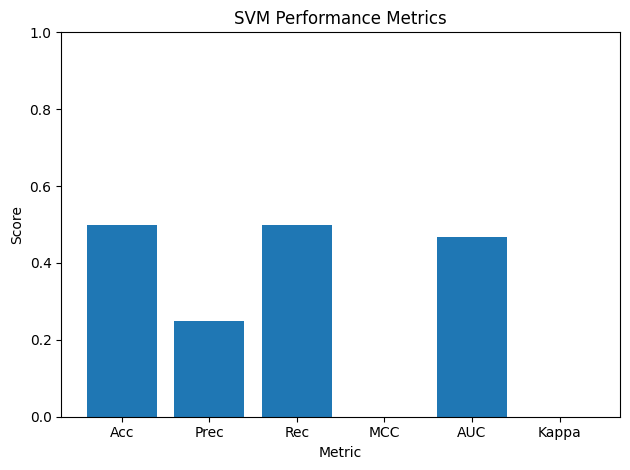

In [18]:
metrics_svm = [acc_svm, prec_svm, rec_svm, mcc_svm, auc_svm, kappa_svm]
names_svm   = ["Acc","Prec","Rec","MCC","AUC","Kappa"]

plt.figure()
plt.bar(names_svm, metrics_svm)
plt.ylim(0, 1)
plt.title("SVM Performance Metrics")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.tight_layout()

svm_metrics_plot_path = "svm_metrics_plot.png"
plt.savefig(svm_metrics_plot_path, dpi=300)
print(f"SVM metrik grafiği '{svm_metrics_plot_path}' dosyasına kaydedildi.")

plt.show()


SVM confusion matrix görseli 'svm_confusion_matrix.png' dosyasına kaydedildi.


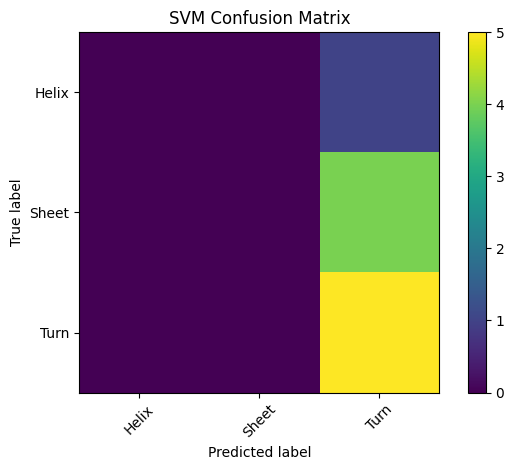

Confusion Matrix (SVM):
[[0 0 1]
 [0 0 4]
 [0 0 5]]


In [19]:
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure()
plt.imshow(cm_svm, interpolation='nearest')
plt.title("SVM Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

svm_cm_plot_path = "svm_confusion_matrix.png"
plt.savefig(svm_cm_plot_path, dpi=300)
print(f"SVM confusion matrix görseli '{svm_cm_plot_path}' dosyasına kaydedildi.")

plt.show()

print("Confusion Matrix (SVM):")
print(cm_svm)


In [20]:
# Girdiyi 3D hale getir (CNN için)
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Çıktıyı one-hot yap
num_classes = len(class_to_int)
y_train_cnn = to_categorical(y_train, num_classes=num_classes)
y_test_cnn  = to_categorical(y_test, num_classes=num_classes)

X_train_cnn.shape, y_train_cnn.shape


((40, 20, 1), (40, 3))

In [21]:
model_cnn = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 18, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 7, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,795 (194.51 KB)

 Trainable params: 49,795 (194.51 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model_cnn.fit(
    X_train_cnn, y_train_cnn,
    epochs=30,
    batch_size=8,
    validation_data=(X_test_cnn, y_test_cnn),
    verbose=1
)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - accuracy: 0.4712 - loss: 1.0890 - val_accuracy: 0.5000 - val_loss: 1.0597
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4674 - loss: 1.0546 - val_accuracy: 0.5000 - val_loss: 1.0100
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4517 - loss: 1.0177 - val_accuracy: 0.5000 - val_loss: 0.9691
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4622 - loss: 1.0035 - val_accuracy: 0.5000 - val_loss: 0.9497
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5090 - loss: 0.9322 - val_accuracy: 0.5000 - val_loss: 0.9460
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4622 - loss: 0.9388 - val_accuracy: 0.5000 - val_loss: 0.9464
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5146 - loss: 0.9463 - val_accuracy: 0.2000 - val_loss: 0.9497
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6545 - loss: 1.0440 - val_accuracy: 0.5000 - val_loss: 0.9481

1D-CNN loss grafiği 'cnn_loss_plot.png' dosyasına kaydedildi.


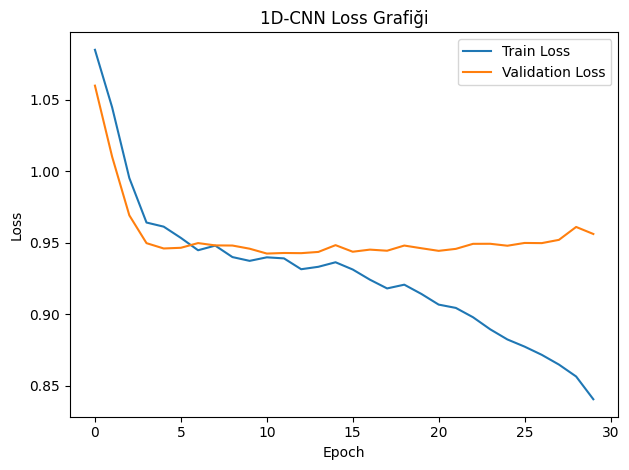

1D-CNN accuracy grafiği 'cnn_accuracy_plot.png' dosyasına kaydedildi.


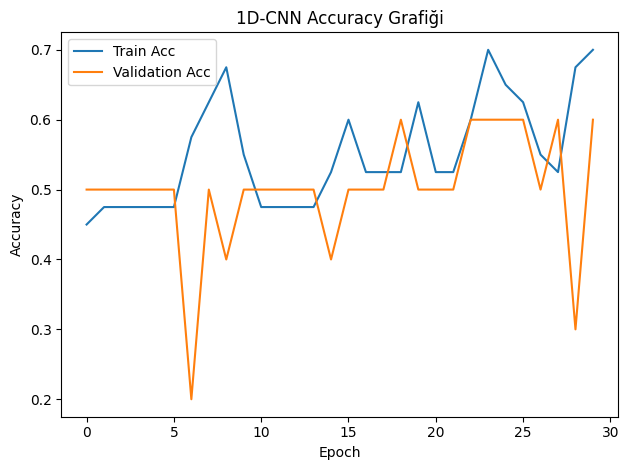

In [29]:
# Loss grafiği
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("1D-CNN Loss Grafiği")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()

cnn_loss_plot_path = "cnn_loss_plot.png"
plt.savefig(cnn_loss_plot_path, dpi=300)
print(f"1D-CNN loss grafiği '{cnn_loss_plot_path}' dosyasına kaydedildi.")

plt.show()

# Accuracy grafiği
plt.figure()
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.title("1D-CNN Accuracy Grafiği")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()

cnn_acc_plot_path = "cnn_accuracy_plot.png"
plt.savefig(cnn_acc_plot_path, dpi=300)
print(f"1D-CNN accuracy grafiği '{cnn_acc_plot_path}' dosyasına kaydedildi.")

plt.show()


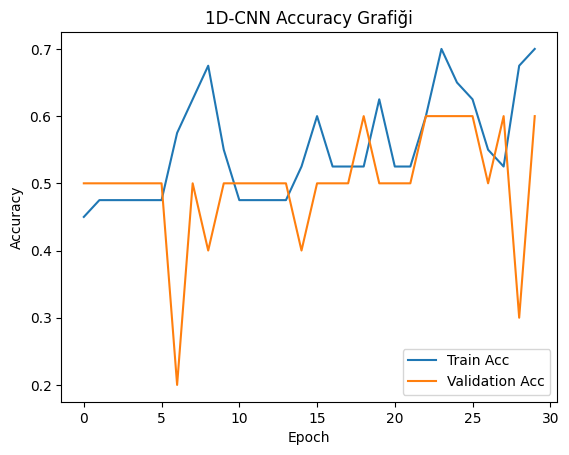

In [24]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.title("1D-CNN Accuracy Grafiği")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [25]:
y_proba_cnn = model_cnn.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_proba_cnn, axis=1)

acc_cnn   = accuracy_score(y_test, y_pred_cnn)
prec_cnn  = precision_score(y_test, y_pred_cnn, average="weighted")
rec_cnn   = recall_score(y_test, y_pred_cnn, average="weighted")
mcc_cnn   = matthews_corrcoef(y_test, y_pred_cnn)
kappa_cnn = cohen_kappa_score(y_test, y_pred_cnn)

auc_cnn = roc_auc_score(y_test_cnn, y_proba_cnn, multi_class="ovr")

print("=== 1D-CNN METRİKLERİ ===")
print("Accuracy :", acc_cnn)
print("Precision:", prec_cnn)
print("Recall   :", rec_cnn)
print("MCC      :", mcc_cnn)
print("Kappa    :", kappa_cnn)
print("AUC      :", auc_cnn)

print("\n=== 1D-CNN Classification Report ===")
print(classification_report(y_test, y_pred_cnn, target_names=classes))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
=== 1D-CNN METRİKLERİ ===
Accuracy : 0.6
Precision: 0.5125
Recall   : 0.6
MCC      : 0.2785430072655778
Kappa    : 0.23076923076923084
AUC      : 0.5112962962962962

=== 1D-CNN Classification Report ===
              precision    recall  f1-score   support

       Helix       0.00      0.00      0.00         1
       Sheet       0.50      0.25      0.33         4
        Turn       0.62      1.00      0.77         5

    accuracy                           0.60        10
   macro avg       0.38      0.42      0.37        10
weighted avg       0.51      0.60      0.52        10



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [26]:
cnn_report_path = "cnn_report.txt"
with open(cnn_report_path, "w") as f:
    f.write("=== 1D-CNN METRİKLERİ ===\n")
    f.write(f"Accuracy : {acc_cnn:.4f}\n")
    f.write(f"Precision: {prec_cnn:.4f}\n")
    f.write(f"Recall   : {rec_cnn:.4f}\n")
    f.write(f"MCC      : {mcc_cnn:.4f}\n")
    f.write(f"Kappa    : {kappa_cnn:.4f}\n")
    f.write(f"AUC      : {auc_cnn:.4f}\n\n")

    f.write("=== 1D-CNN Classification Report ===\n")
    f.write(classification_report(y_test, y_pred_cnn, target_names=classes))

print(f"1D-CNN raporu '{cnn_report_path}' dosyasına kaydedildi.")


1D-CNN raporu 'cnn_report.txt' dosyasına kaydedildi.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1D-CNN confusion matrix görseli 'cnn_confusion_matrix.png' dosyasına kaydedildi.


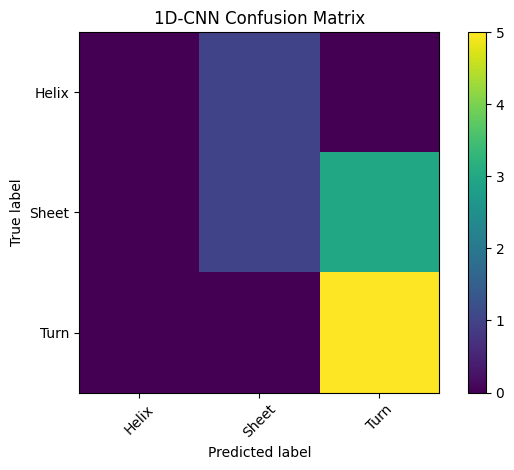

Confusion Matrix (1D-CNN):
[[0 1 0]
 [0 1 3]
 [0 0 5]]


In [30]:
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

plt.figure()
plt.imshow(cm_cnn, interpolation='nearest')
plt.title("1D-CNN Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

cnn_cm_plot_path = "cnn_confusion_matrix.png"
plt.savefig(cnn_cm_plot_path, dpi=300)
print(f"1D-CNN confusion matrix görseli '{cnn_cm_plot_path}' dosyasına kaydedildi.")

plt.show()

print("Confusion Matrix (1D-CNN):")
print(cm_cnn)


1D-CNN ROC eğrileri 'cnn_roc_curves.png' dosyasına kaydedildi.


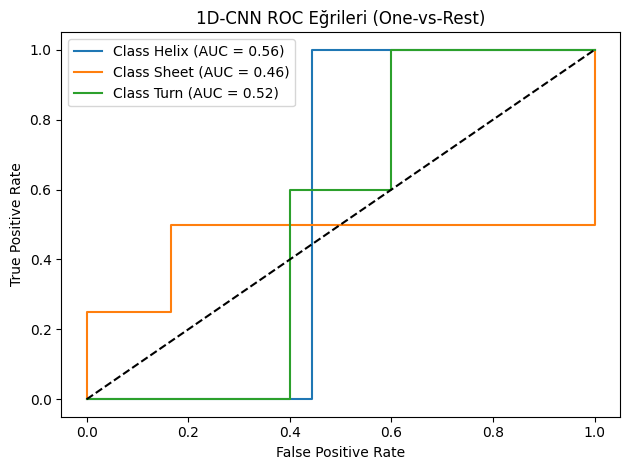

In [31]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cnn[:, i], y_proba_cnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("1D-CNN ROC Eğrileri (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()

cnn_roc_plot_path = "cnn_roc_curves.png"
plt.savefig(cnn_roc_plot_path, dpi=300)
print(f"1D-CNN ROC eğrileri '{cnn_roc_plot_path}' dosyasına kaydedildi.")

plt.show()
